## Sea Ice Diagnostics for two CESM3 runs

In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import yaml
import pandas as pd

In [2]:
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
cases = ["b.e23_alpha16g.BLT1850.ne30_t232.075","b.e23_alpha16g.BLT1850.ne30_t232.078"]

begyr1 = 1
endyr1 = 102
begyr2 = 1
endyr2 = 48
nyears = 25

In [3]:
# Parameters
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
cases = ["b.e23_alpha16g.BLT1850.ne30_t232.075", "b.e23_alpha16g.BLT1850.ne30_t232.078"]
subset_kwargs = {}
product = "/glade/u/home/dbailey/CUPiD/examples/coupled_model/computed_notebooks/quick-run/seaice.ipynb"


In [4]:
# Read in two cases. The ADF timeseries are needed here.

case1 = cases[0]
case2 = cases[1]

cbegyr1 = f"{begyr1:04d}"
cendyr1 = f"{endyr1:04d}"
cbegyr2 = f"{begyr2:04d}"
cendyr2 = f"{endyr2:04d}"

ds1 = xr.open_mfdataset(CESM_output_dir+"/"+case1+"/ts/"+case1+".cice.h."+"*."+cbegyr1+"01-"+cendyr1+"12.nc")
ds2 = xr.open_mfdataset(CESM_output_dir+"/"+case2+"/ts/"+case2+".cice.h."+"*."+cbegyr2+"01-"+cendyr2+"12.nc")

TLAT = ds1['TLAT']
TLON = ds1['TLON']
tarea = ds1['tarea']

# Make a DataArray with the number of days in each month, size = len(time)
month_length = ds1.time.dt.days_in_month
weights_monthly = month_length.groupby("time.year") / month_length.groupby("time.year").sum()


#seasons = xr.full_like(months, fill_value="none", dtype="U4")
#seasons.name = "season"
#seasons[months.isin([1, 2, 3])] = "JFM"
#seasons[months.isin([4, 5, 6])] = "AMJ"
#seasons[months.isin([7, 8, 9])] = "JAS"
#seasons[months.isin([10, 11, 12])] = "OND"
#weights_season = month_length.groupby(seasons) / month_length.groupby(seasons).sum()

ds1_ann = (ds1 * weights_monthly).resample(time="YS").sum(dim="time")
ds2_ann = (ds2 * weights_monthly).resample(time="YS").sum(dim="time")


#ds1_seas = (ds1 * weights_season).resample(time="QS-JAN").sum(dim="time")
#ds2_seas = (ds2 * weights_season).resample(time="QS-JAN").sum(dim="time")

with open('cice_masks.yml', 'r') as file:
    cice_masks = yaml.safe_load(file)

with open('cice_vars.yml', 'r') as file:
    cice_vars = yaml.safe_load(file)

print(ds1['aice'])


<xarray.DataArray 'aice' (time: 1224, nj: 480, ni: 540)>
dask.array<open_dataset-aice, shape=(1224, 480, 540), dtype=float32, chunksize=(2, 480, 540), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0102-12-16 12:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged


In [5]:
def plot_diff(field1, field2, levels, case1, case2, title, proj):
   # make circular boundary for polar stereographic circular plots
   theta = np.linspace(0, 2*np.pi, 100)
   center, radius = [0.5, 0.5], 0.5
   verts = np.vstack([np.sin(theta), np.cos(theta)]).T
   circle = mpath.Path(verts * radius + center)

   
   if (np.size(levels) > 2):
       cmap = mpl.colormaps['tab20']
       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)

   # set up the figure with a North Polar Stereographic projection
   fig = plt.figure(tight_layout=True)
   gs = GridSpec(2, 4)

   if (proj == "N"):
      ax = fig.add_subplot(gs[0,:2], projection=ccrs.NorthPolarStereo())
      # sets the latitude / longitude boundaries of the plot
      ax.set_extent([0.005, 360, 90, 45], crs=ccrs.PlateCarree())
   if (proj == "S"):
      ax = fig.add_subplot(gs[0,:2], projection=ccrs.SouthPolarStereo())
      # sets the latitude / longitude boundaries of the plot
      ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())

   ax.set_boundary(circle, transform=ax.transAxes)
   ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

   field_diff = field2.values-field1.values
   field_std = field_diff.std()

   this=ax.pcolormesh(TLON,
                      TLAT,
                      field1,
                      norm = norm,
                      cmap="tab20",
                      transform=ccrs.PlateCarree())
   plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
   plt.title(case1,fontsize=10)

   if (proj == "N"):
      ax = fig.add_subplot(gs[0,2:], projection=ccrs.NorthPolarStereo())
      # sets the latitude / longitude boundaries of the plot
      ax.set_extent([0.005, 360, 90, 45], crs=ccrs.PlateCarree())
   if (proj == "S"):
      ax = fig.add_subplot(gs[0,2:], projection=ccrs.SouthPolarStereo())
      # sets the latitude / longitude boundaries of the plot
      ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())

   ax.set_boundary(circle, transform=ax.transAxes)
   ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

   this=ax.pcolormesh(TLON,
                      TLAT,
                      field2,
                      norm=norm,
                      cmap="tab20",
                      transform=ccrs.PlateCarree())
   plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
   plt.title(case2,fontsize=10)

   if (proj == "N"):
      ax = fig.add_subplot(gs[1,1:3], projection=ccrs.NorthPolarStereo())
      # sets the latitude / longitude boundaries of the plot
      ax.set_extent([0.005, 360, 90, 45], crs=ccrs.PlateCarree())
   if (proj == "S"):
      ax = fig.add_subplot(gs[1,1:3], projection=ccrs.SouthPolarStereo())
      # sets the latitude / longitude boundaries of the plot
      ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())

   ax.set_boundary(circle, transform=ax.transAxes)
   ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

   this=ax.pcolormesh(TLON,
                      TLAT,
                      field_diff,
                      cmap="seismic",vmax=field_std*2.0,vmin=-field_std*2.0,
                      transform=ccrs.PlateCarree())
   plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
   plt.title(case2+"-"+case1,fontsize=10)

   plt.suptitle(title)


In [6]:
def vect_diff(uvel1,vvel1,uvel2,vvel2,angle,proj):
    uvel_rot1 = uvel1*np.cos(angle)-vvel1*np.sin(angle)
    vvel_rot1 = uvel1*np.sin(angle)+vvel1*np.cos(angle)
    uvel_rot2 = uvel2*np.cos(angle)-vvel2*np.sin(angle)
    vvel_rot2 = uvel2*np.sin(angle)+vvel2*np.cos(angle)
    
    speed1 = np.sqrt(uvel1*uvel1+vvel1*vvel1)
    speed2 = np.sqrt(uvel2*uvel2+vvel2*vvel2)

    uvel_diff = uvel_rot2-uvel_rot1
    vvel_diff = vvel_rot2-vvel_rot1
    speed_diff = speed2-speed1
    
    # make circular boundary for polar stereographic circular plots
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    # set up the figure with a North Polar Stereographic projection
    fig = plt.figure(tight_layout=True)
    gs = GridSpec(2, 4)

    if (proj == "N"):
       ax = fig.add_subplot(gs[0,:2], projection=ccrs.NorthPolarStereo())
       # sets the latitude / longitude boundaries of the plot
       ax.set_extent([0.005, 360, 90, 45], crs=ccrs.PlateCarree())
    if (proj == "S"):
       ax = fig.add_subplot(gs[0,:2], projection=ccrs.SouthPolarStereo())
       # sets the latitude / longitude boundaries of the plot
       ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

    this=ax.pcolormesh(TLON,
                     TLAT,
                     speed1,
                     vmin = 0.,
                     vmax = 0.5,
                     cmap="tab20",
                     transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    plt.title(case1,fontsize=10)

    intv = 5
    ## add vectors
    Q = ax.quiver(TLON[::intv,::intv].values,TLAT[::intv,::intv].values,
                  uvel_rot1[::intv,::intv].values,vvel_rot1[::intv,::intv].values,
                  color = 'black', scale=1.,
                  transform=ccrs.PlateCarree())
    units = "cm/s"
    qk = ax.quiverkey(Q,0.85,0.025,0.10,r'10 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)

    if (proj == "N"):
       ax = fig.add_subplot(gs[0,2:], projection=ccrs.NorthPolarStereo())
       # sets the latitude / longitude boundaries of the plot
       ax.set_extent([0.005, 360, 90, 45], crs=ccrs.PlateCarree())
    if (proj == "S"):
       ax = fig.add_subplot(gs[0,2:], projection=ccrs.SouthPolarStereo())
       # sets the latitude / longitude boundaries of the plot
       ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())
        
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

    this=ax.pcolormesh(TLON,
                     TLAT,
                     speed2,
                     vmin = 0.,
                     vmax = 0.5,
                     cmap="tab20",
                     transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    plt.title(case1,fontsize=10)

    intv = 5
    ## add vectors
    Q = ax.quiver(TLON[::intv,::intv].values,TLAT[::intv,::intv].values,
                  uvel_rot2[::intv,::intv].values,vvel_rot2[::intv,::intv].values,
                  color = 'black', scale=1.,
                  transform=ccrs.PlateCarree())
    units = "cm/s"
    qk = ax.quiverkey(Q,0.85,0.025,0.10,r'10 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)

    if (proj == "N"):
       ax = fig.add_subplot(gs[1,1:3], projection=ccrs.NorthPolarStereo())
       # sets the latitude / longitude boundaries of the plot
       ax.set_extent([0.005, 360, 90, 45], crs=ccrs.PlateCarree())
    if (proj == "S"):
       ax = fig.add_subplot(gs[1,1:3], projection=ccrs.SouthPolarStereo())
       # sets the latitude / longitude boundaries of the plot
       ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())
        
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

    this=ax.pcolormesh(TLON,
                     TLAT,
                     speed_diff,
                     vmin = -0.2,
                     vmax = 0.2,
                     cmap="seismic",
                     transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    plt.title(case2+"-"+case1,fontsize=10)

    intv = 5
    ## add vectors
    Q = ax.quiver(TLON[::intv,::intv].values,TLAT[::intv,::intv].values,
                  uvel_diff[::intv,::intv].values,vvel_diff[::intv,::intv].values,
                  color = 'black', scale=1.,
                  transform=ccrs.PlateCarree())
    units = "cm/s"
    qk = ax.quiverkey(Q,0.85,0.025,0.10,r'10 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)

    plt.suptitle("Velocity m/s")

aice [{'levels': [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]}, {'title': 'Sea Ice Concentration'}]
[0.05 0.1  0.15 0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.85 0.9  0.95 0.99]


hi [{'levels': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}, {'title': 'Sea Ice Thickness (m)'}]
[0.05 0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.  ]


hs [{'levels': [0.01, 0.03, 0.05, 0.07, 0.1, 0.13, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}, {'title': 'Snow Depth (m)'}]
[0.01 0.03 0.05 0.07 0.1  0.13 0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


Tsfc [{'levels': [-40.0, -37.0, -34.0, -31.0, -28.0, -25.0, -22.0, -19.0, -16.0, -13.0, -10.0, -5.0, -3.0, -1.0]}, {'title': 'Surface Temperature (C)'}]
[-40. -37. -34. -31. -28. -25. -22. -19. -16. -13. -10.  -5.  -3.  -1.]


albsni [{'levels': [5, 10, 15, 20, 30, 40, 50, 60, 65, 70, 75, 80, 85, 90]}, {'title': 'Snow Ice Albedo'}]
[ 5 10 15 20 30 40 50 60 65 70 75 80 85 90]


flat [{'levels': [-18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 2.0]}, {'title': 'Latent Heat Flux (W/m^2}'}]
[-18. -16. -14. -12. -10.  -8.  -6.  -5.  -4.  -3.  -2.  -1.   0.   2.]


fsens [{'levels': [-30.0, -25.0, -20.0, -15.0, -10.0, -5.0, -2.5, 0, 2.5, 5, 10, 15, 20, 25]}, {'title': 'Sensible Heat Flux (W/m^2)'}]
[-30.  -25.  -20.  -15.  -10.   -5.   -2.5   0.    2.5   5.   10.   15.
  20.   25. ]


congel [{'levels': [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]}, {'title': 'Congelation growth (cm/day)'}]
[ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10. ]


frazil [{'levels': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26]}, {'title': 'Frazil growth (cm/day)'}]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26]


snoice [{'levels': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]}, {'title': 'Snow-ice growth (cm/day)'}]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


meltb [{'levels': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}, {'title': 'Bottom Melt (cm/day)'}]
[0.05 0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.  ]


meltt [{'levels': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]}, {'title': 'Top Melt (cm/day)'}]
[0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3 ]


meltl [{'levels': [0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52]}, {'title': 'Lateral Melt (cm/day)'}]
[0.01 0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52]


dvidtt [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Volume tendency due to thermodynamics (cm/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


dvidtd [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Volume tendency due to dynamics (cm/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


daidtt [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Area tendency due to thermodynamics (%/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


daidtd [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Area tendency due to dynamics (%/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


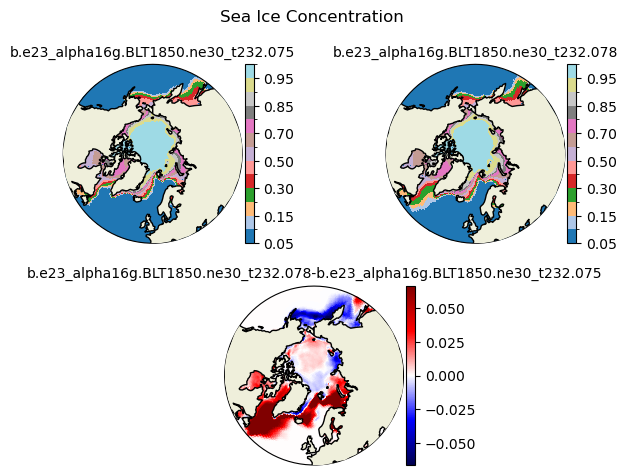

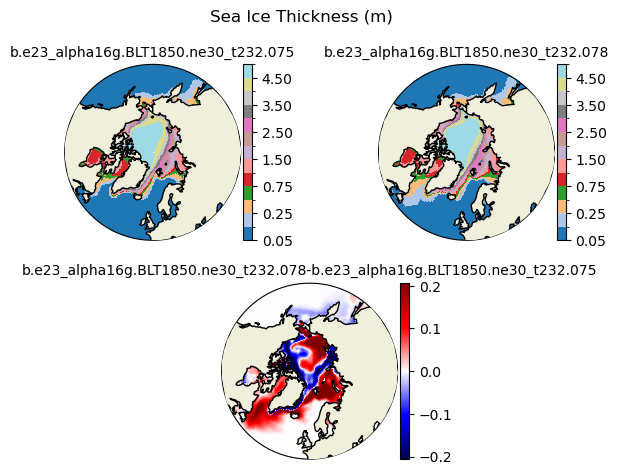

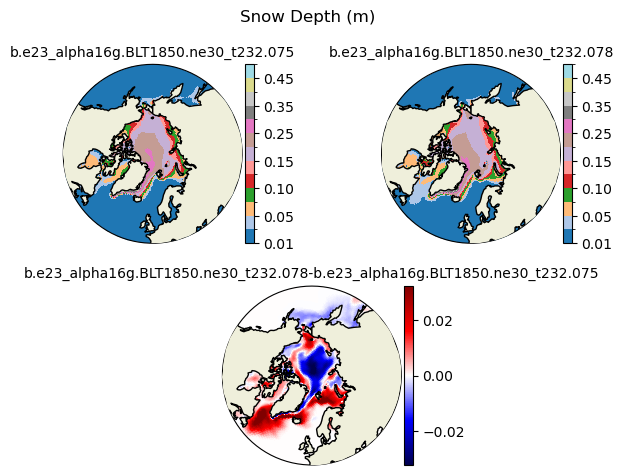

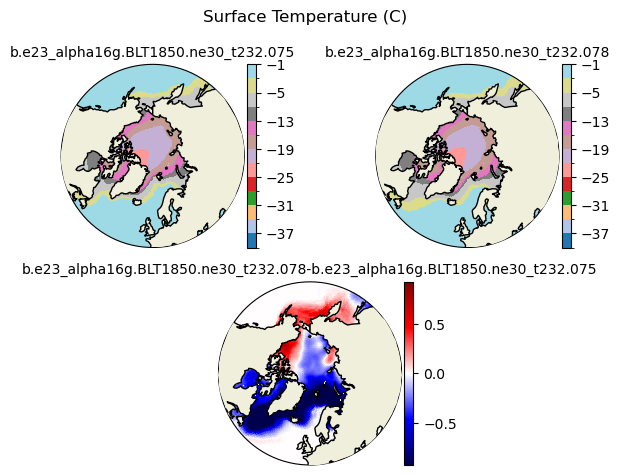

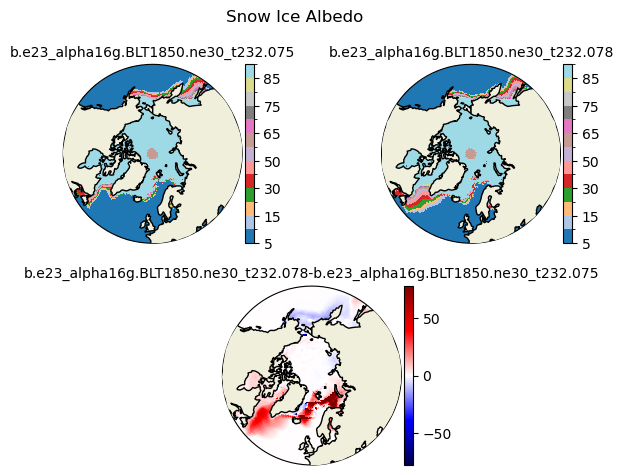

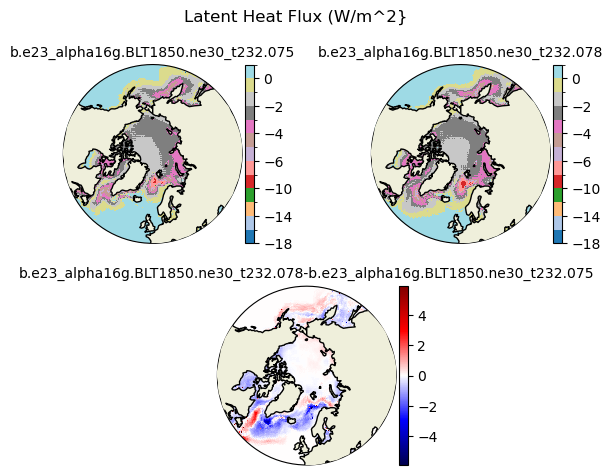

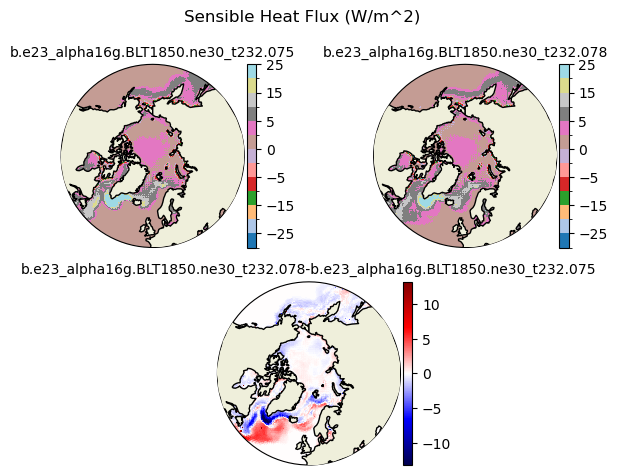

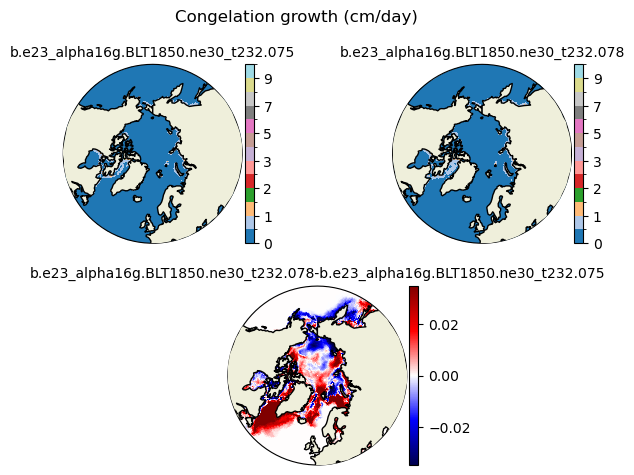

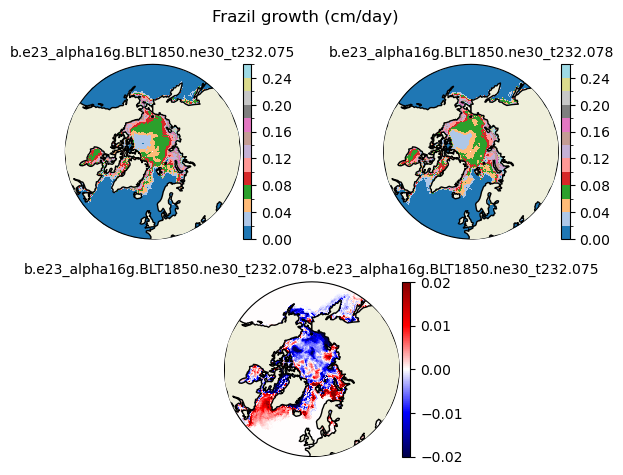

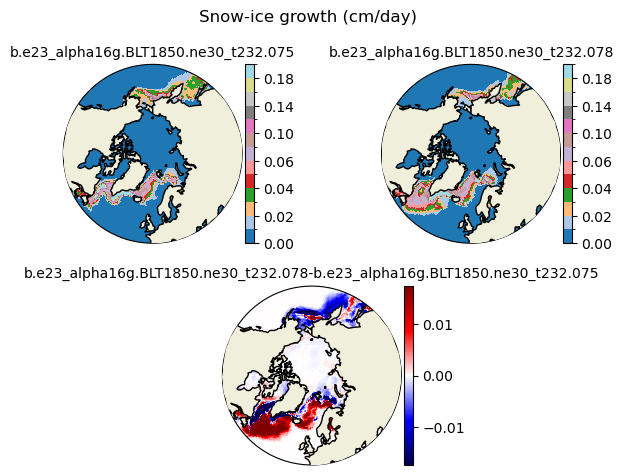

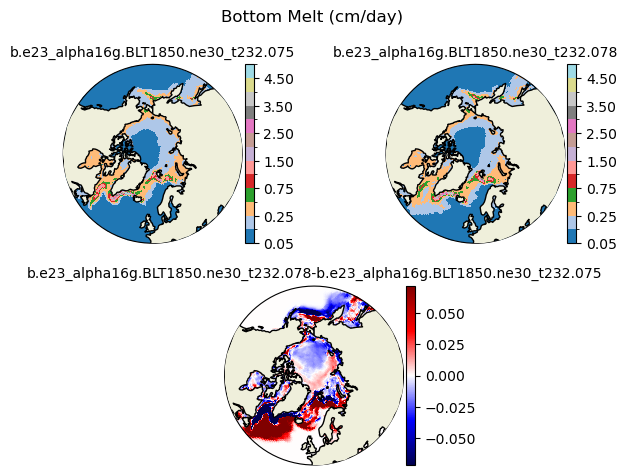

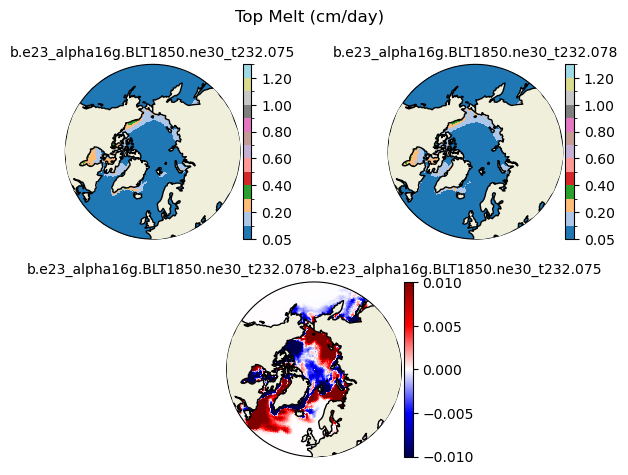

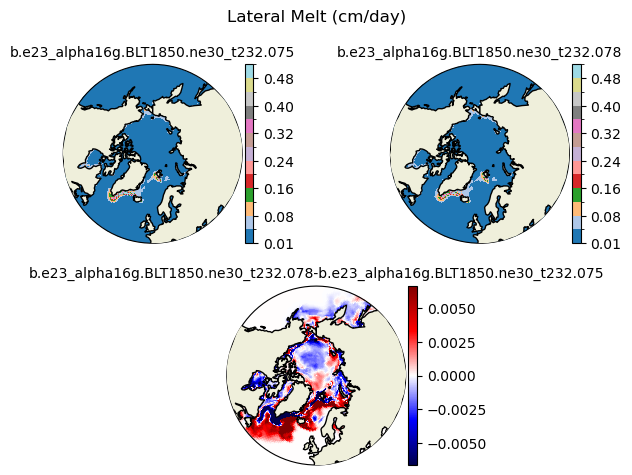

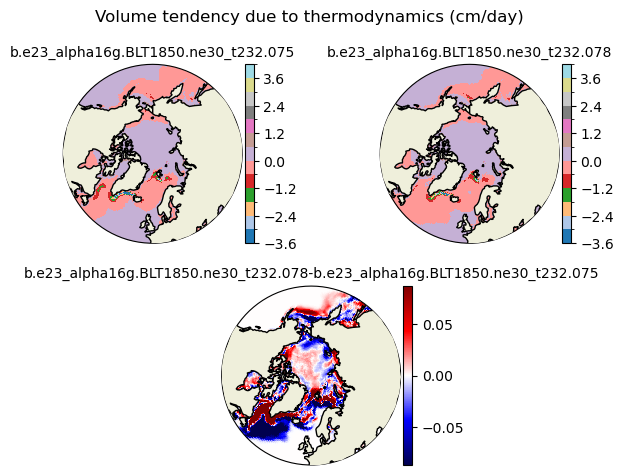

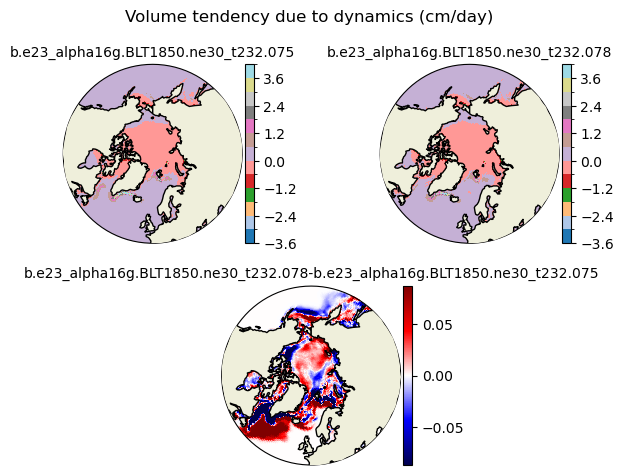

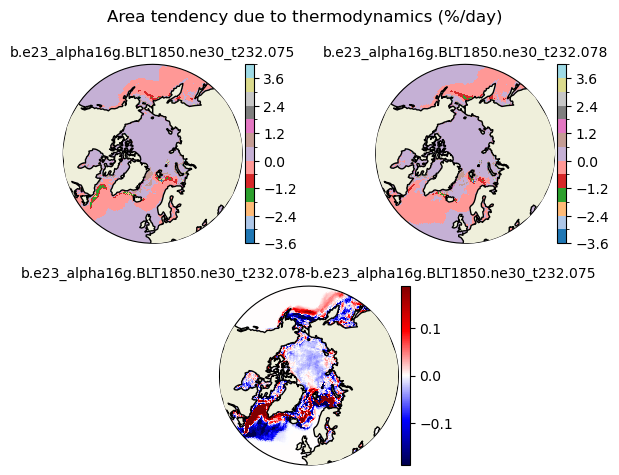

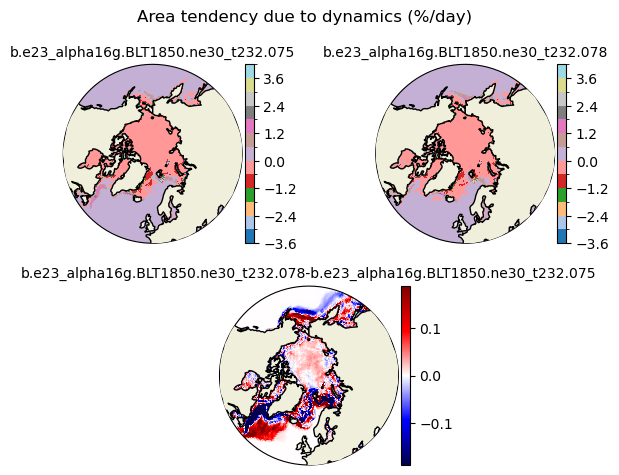

In [7]:
with open('cice_vars.yml', 'r') as file:
    cice_vars = yaml.safe_load(file)


for var in cice_vars:
    print(var,cice_vars[var])
    vmin=cice_vars[var][0]['levels'][0]
    vmax=cice_vars[var][0]['levels'][-1]
    levels = np.array(cice_vars[var][0]['levels'])
    print(levels)
    title=cice_vars[var][1]['title']
    field1 = ds1_ann[var].isel(time=slice(-nyears,None)).mean("time").squeeze()
    field2 = ds2_ann[var].isel(time=slice(-nyears,None)).mean("time").squeeze()
    plot_diff(field1,field2,levels,case1,case2,title,"N")

aice [{'levels': [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]}, {'title': 'Sea Ice Concentration'}]
[0.05 0.1  0.15 0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.85 0.9  0.95 0.99]


hi [{'levels': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}, {'title': 'Sea Ice Thickness (m)'}]
[0.05 0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.  ]


hs [{'levels': [0.01, 0.03, 0.05, 0.07, 0.1, 0.13, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}, {'title': 'Snow Depth (m)'}]
[0.01 0.03 0.05 0.07 0.1  0.13 0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


Tsfc [{'levels': [-40.0, -37.0, -34.0, -31.0, -28.0, -25.0, -22.0, -19.0, -16.0, -13.0, -10.0, -5.0, -3.0, -1.0]}, {'title': 'Surface Temperature (C)'}]
[-40. -37. -34. -31. -28. -25. -22. -19. -16. -13. -10.  -5.  -3.  -1.]


albsni [{'levels': [5, 10, 15, 20, 30, 40, 50, 60, 65, 70, 75, 80, 85, 90]}, {'title': 'Snow Ice Albedo'}]
[ 5 10 15 20 30 40 50 60 65 70 75 80 85 90]


flat [{'levels': [-18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 2.0]}, {'title': 'Latent Heat Flux (W/m^2}'}]
[-18. -16. -14. -12. -10.  -8.  -6.  -5.  -4.  -3.  -2.  -1.   0.   2.]


fsens [{'levels': [-30.0, -25.0, -20.0, -15.0, -10.0, -5.0, -2.5, 0, 2.5, 5, 10, 15, 20, 25]}, {'title': 'Sensible Heat Flux (W/m^2)'}]
[-30.  -25.  -20.  -15.  -10.   -5.   -2.5   0.    2.5   5.   10.   15.
  20.   25. ]


congel [{'levels': [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]}, {'title': 'Congelation growth (cm/day)'}]
[ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10. ]


frazil [{'levels': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26]}, {'title': 'Frazil growth (cm/day)'}]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26]


snoice [{'levels': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]}, {'title': 'Snow-ice growth (cm/day)'}]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


meltb [{'levels': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}, {'title': 'Bottom Melt (cm/day)'}]
[0.05 0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.  ]


meltt [{'levels': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]}, {'title': 'Top Melt (cm/day)'}]
[0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3 ]


meltl [{'levels': [0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52]}, {'title': 'Lateral Melt (cm/day)'}]
[0.01 0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52]


dvidtt [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Volume tendency due to thermodynamics (cm/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


dvidtd [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Volume tendency due to dynamics (cm/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


daidtt [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Area tendency due to thermodynamics (%/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


daidtd [{'levels': [-3.6, -3.0, -2.4, -1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.0]}, {'title': 'Area tendency due to dynamics (%/day)'}]
[-3.6 -3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3.   3.6  4. ]


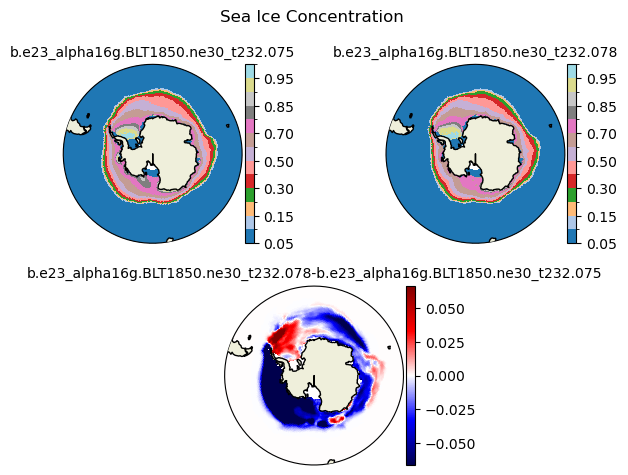

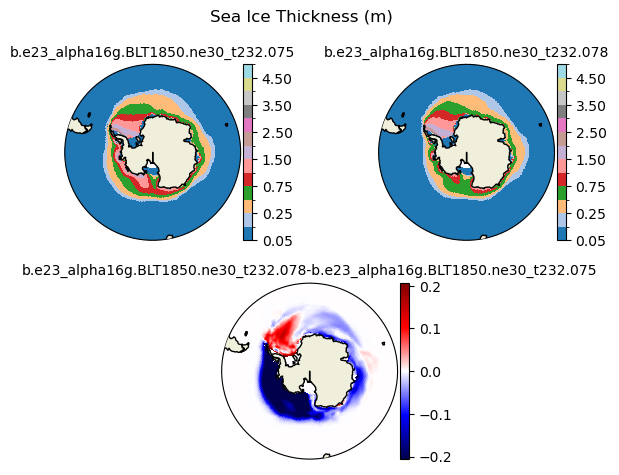

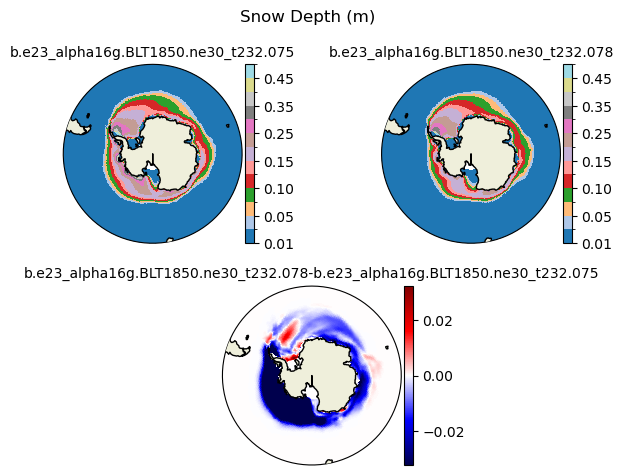

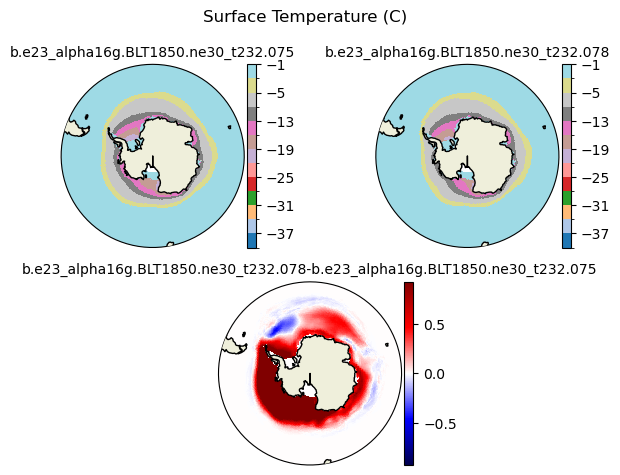

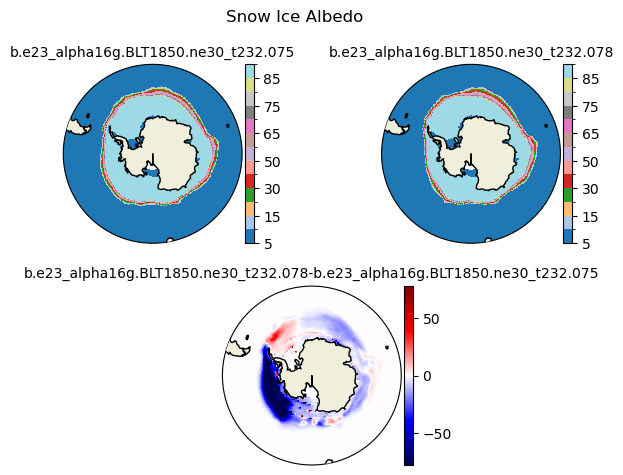

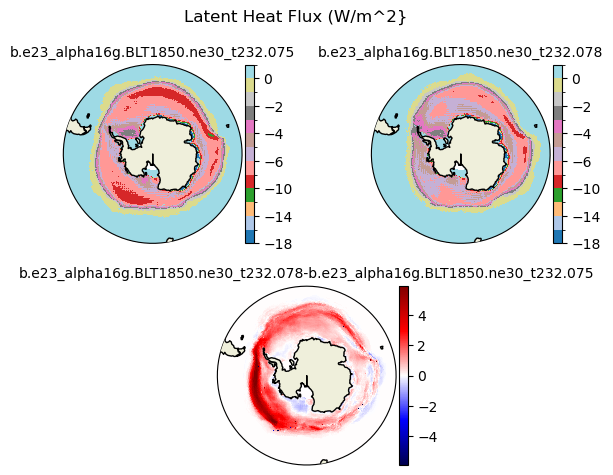

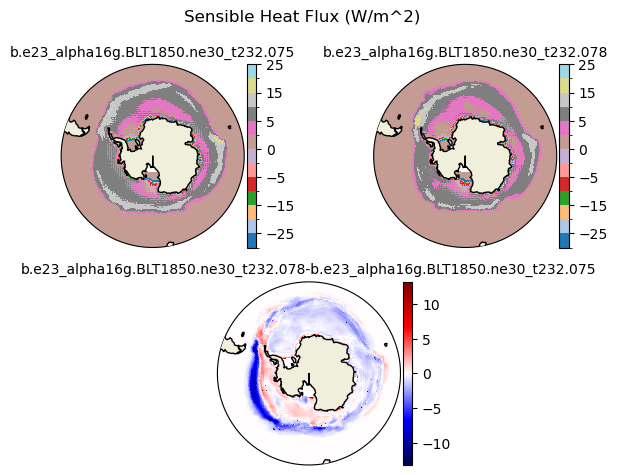

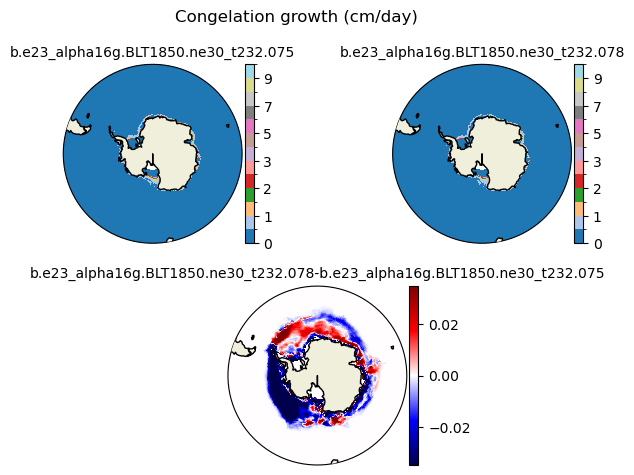

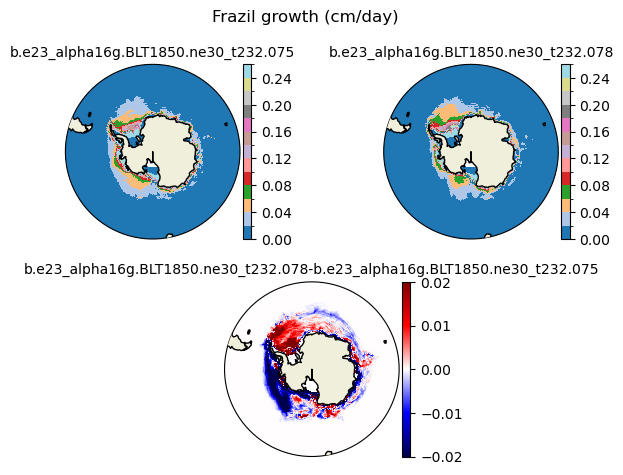

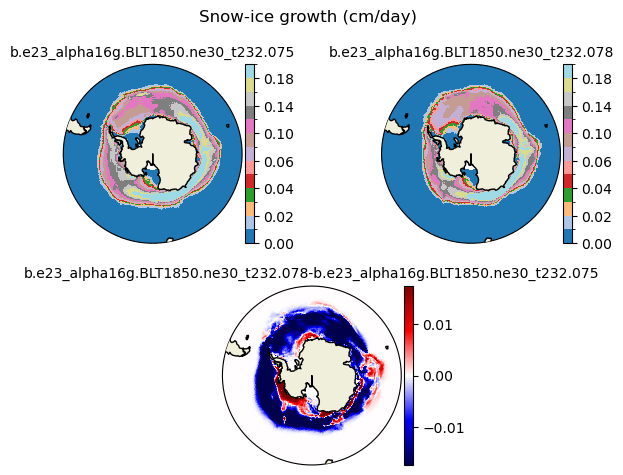

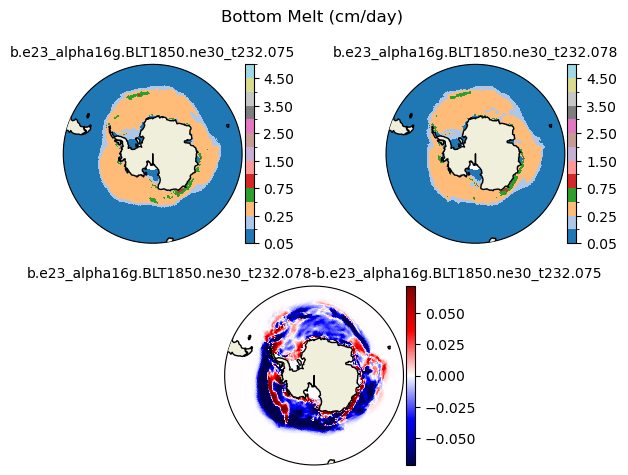

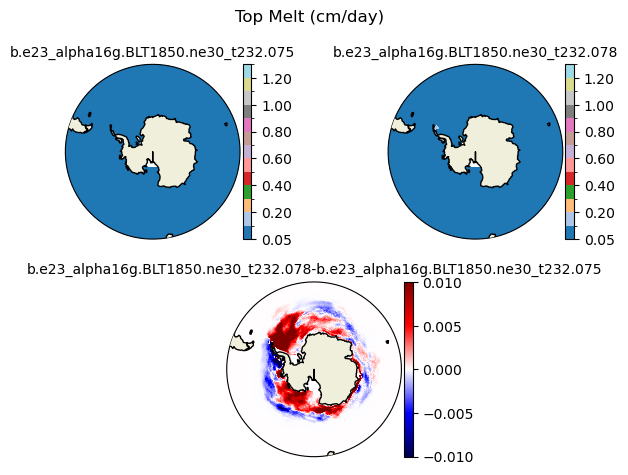

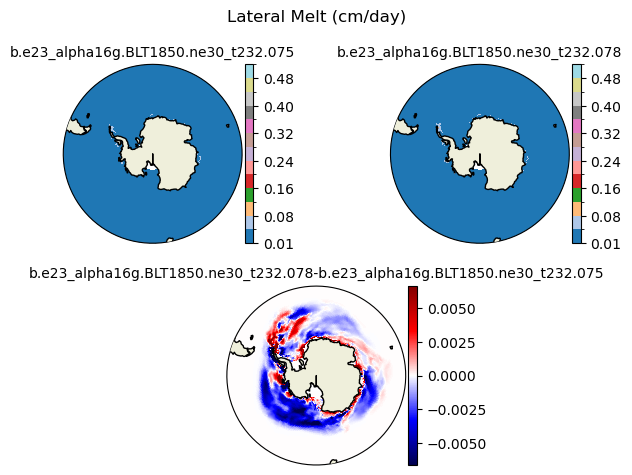

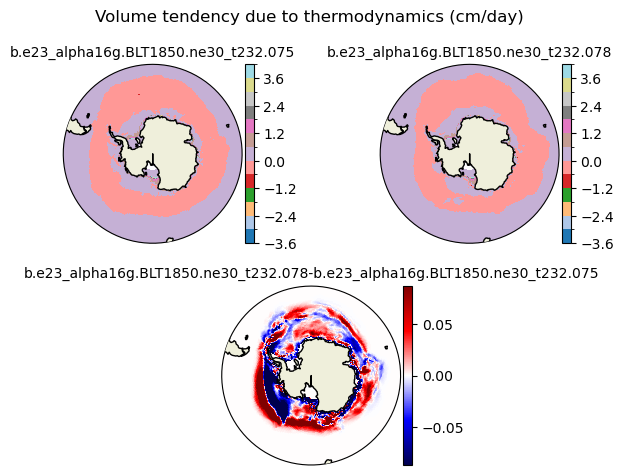

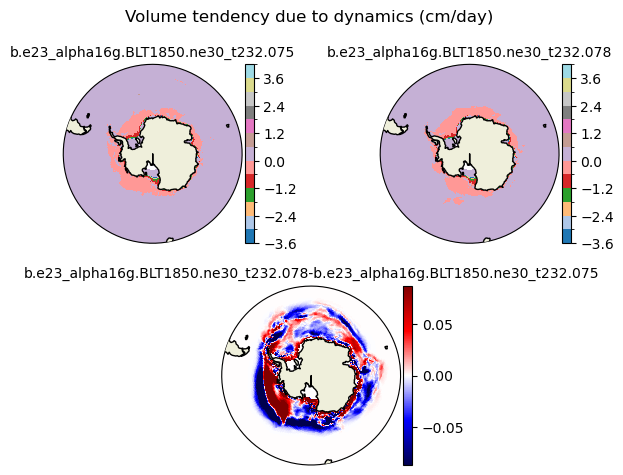

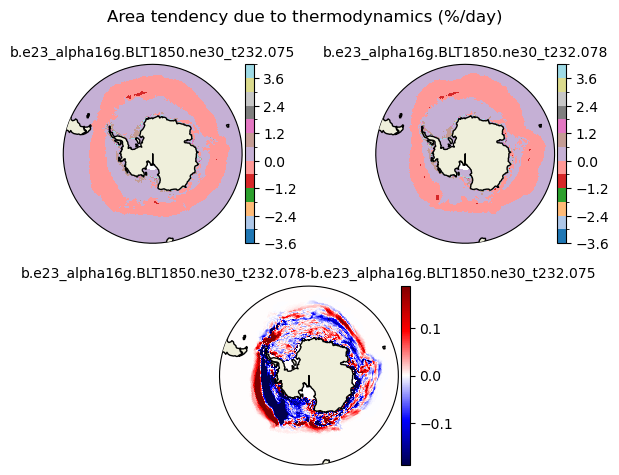

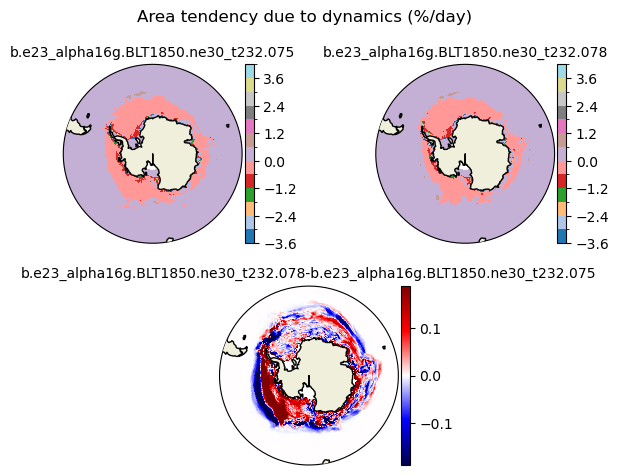

In [8]:
for var in cice_vars:
    print(var,cice_vars[var])
    vmin=cice_vars[var][0]['levels'][0]
    vmax=cice_vars[var][0]['levels'][1]
    levels = np.array(cice_vars[var][0]['levels'])
    print(levels)
    title=cice_vars[var][1]['title']
    field1 = ds1_ann[var].isel(time=slice(-nyears,None)).mean("time").squeeze()
    field2 = ds2_ann[var].isel(time=slice(-nyears,None)).mean("time").squeeze()
    plot_diff(field1,field2,levels,case1,case2,title,"S")

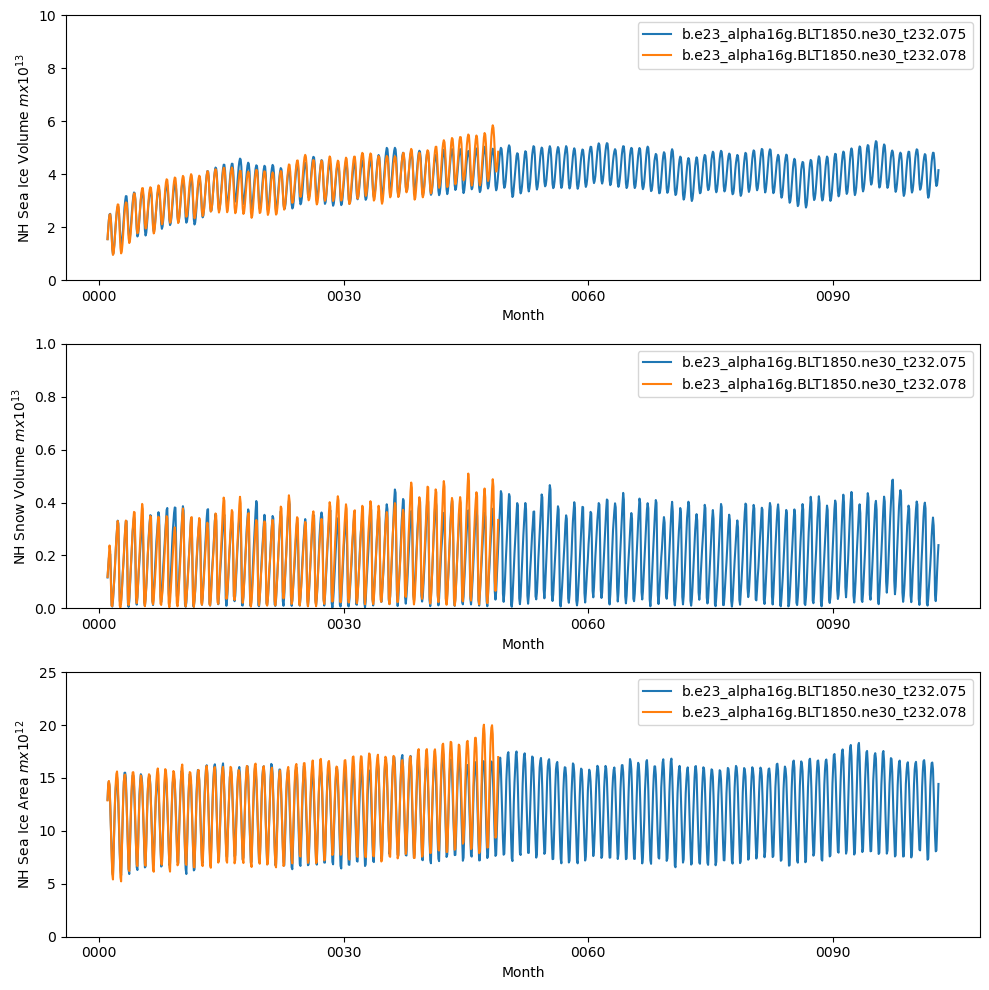

In [9]:
ds1_area = (tarea*ds1.aice).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-12
ds2_area = (tarea*ds2.aice).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-12

ds1_vhi = (tarea*ds1.hi).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13
ds2_vhi = (tarea*ds2.hi).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13

ds1_vhs = (tarea*ds1.hs).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13
ds2_vhs = (tarea*ds2.hs).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13

fig = plt.figure(figsize=(10,10),tight_layout=True)

ax = fig.add_subplot(3,1,1)
ds1_vhi.plot()
ds2_vhi.plot()

plt.ylim((0,10))
plt.xlabel("Month")
plt.ylabel("NH Sea Ice Volume $m x 10^{13}$")
plt.legend([case1,case2])

ax = fig.add_subplot(3,1,2)
ds1_vhs.plot()
ds2_vhs.plot()

plt.ylim((0,1))
plt.xlabel("Month")
plt.ylabel("NH Snow Volume $m x 10^{13}$")
plt.legend([case1,case2])

ax = fig.add_subplot(3,1,3)
ds1_area.plot()
ds2_area.plot()

plt.ylim((0,25))
plt.xlabel("Month")
plt.ylabel("NH Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

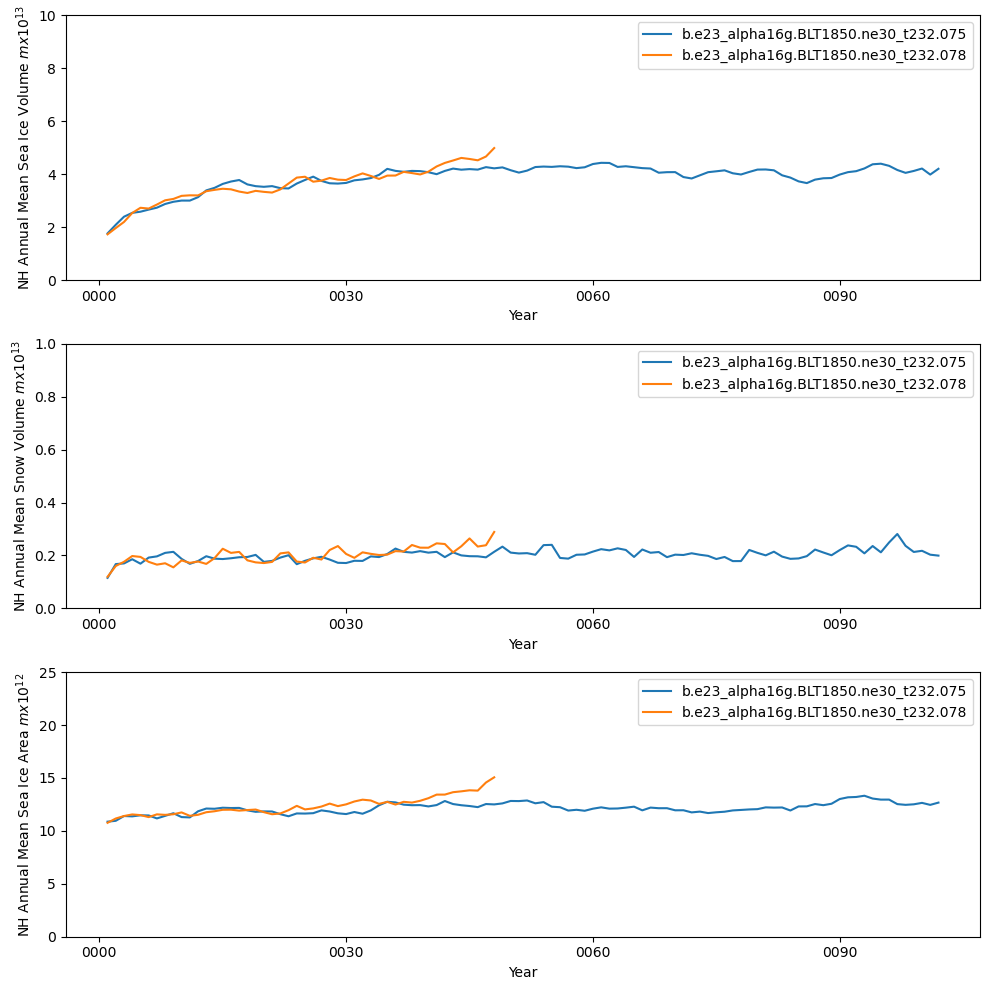

In [10]:
ds1_area_ann = (tarea*ds1_ann['aice']).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-12
ds2_area_ann = (tarea*ds2_ann['aice']).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-12

ds1_vhi_ann = (tarea*ds1_ann['hi']).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13
ds2_vhi_ann = (tarea*ds2_ann['hi']).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13

ds1_vhs_ann = (tarea*ds1_ann['hs']).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13
ds2_vhs_ann = (tarea*ds2_ann['hs']).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-13

fig = plt.figure(figsize=(10,10),tight_layout=True)

ax = fig.add_subplot(3,1,1)
ds1_vhi_ann.plot()
ds2_vhi_ann.plot()

plt.ylim((0,10))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Sea Ice Volume $m x 10^{13}$")
plt.legend([case1,case2])

ax = fig.add_subplot(3,1,2)
ds1_vhs_ann.plot()
ds2_vhs_ann.plot()

plt.ylim((0,1))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Snow Volume $m x 10^{13}$")
plt.legend([case1,case2])

ax = fig.add_subplot(3,1,3)
ds1_area_ann.plot()
ds2_area_ann.plot()

plt.ylim((0,25))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

ds1_area.sel(time=ds1_area.time.dt.month.isin([10])).plot()
ds2_area.sel(time=ds2_area.time.dt.month.isin([10])).plot()

plt.ylim((0,25))
plt.xlabel("Year")
plt.ylabel("NH September Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

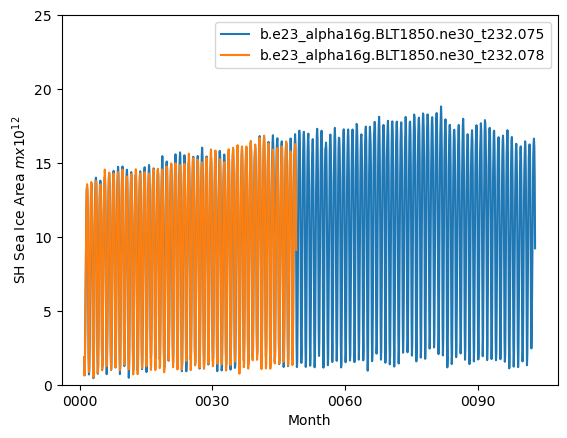

In [11]:
ds1_area = (tarea*ds1.aice).where(TLAT<0).sum(dim=['nj','ni'])*1.0e-12
ds2_area = (tarea*ds2.aice).where(TLAT<0).sum(dim=['nj','ni'])*1.0e-12

ds1_area.plot()
ds2_area.plot()

plt.ylim((0,25))
plt.xlabel("Month")
plt.ylabel("SH Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

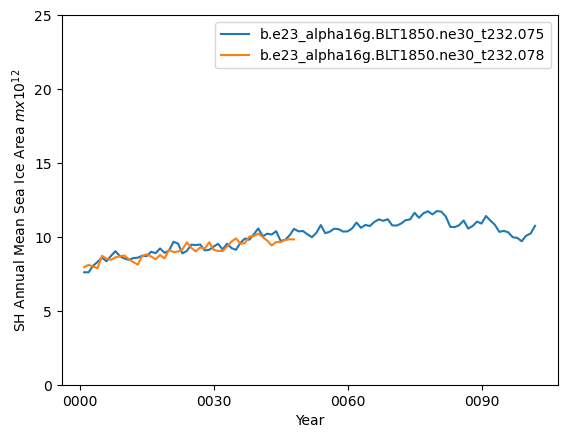

In [12]:
ds1_area_ann = (tarea*ds1_ann.aice).where(TLAT<0).sum(dim=['nj','ni'])*1.0e-12
ds2_area_ann = (tarea*ds2_ann.aice).where(TLAT<0).sum(dim=['nj','ni'])*1.0e-12

ds1_area_ann.plot()
ds2_area_ann.plot()

plt.ylim((0,25))
plt.xlabel("Year")
plt.ylabel("SH Annual Mean Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

[13.67 13.34 13.59 13.34 13.64 13.3  12.99 13.05 13.22   nan 13.63 13.39
 13.11 12.95 13.41 13.32 13.27 12.92 12.86 13.08 12.76 12.64 12.64 12.49
 12.61 12.59 12.55 12.23 11.95 12.03 12.36 12.2  11.83 12.15 12.01 12.18
 12.35 12.04 11.46 11.74 11.86]


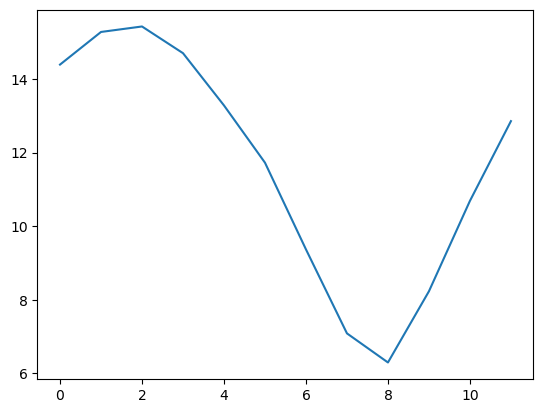

In [13]:
### Read in the NSIDC data from files

path_nsidc = '/glade/campaign/cesm/development/pcwg/ice/data/NSIDC_SeaIce_extent/'

jan_nsidc = pd.read_csv(path_nsidc+'N_01_extent_v3.0.csv',na_values=['-99.9'])
feb_nsidc = pd.read_csv(path_nsidc+'N_02_extent_v3.0.csv',na_values=['-99.9'])
mar_nsidc = pd.read_csv(path_nsidc+'N_03_extent_v3.0.csv',na_values=['-99.9'])
apr_nsidc = pd.read_csv(path_nsidc+'N_04_extent_v3.0.csv',na_values=['-99.9'])
may_nsidc = pd.read_csv(path_nsidc+'N_05_extent_v3.0.csv',na_values=['-99.9'])
jun_nsidc = pd.read_csv(path_nsidc+'N_06_extent_v3.0.csv',na_values=['-99.9'])
jul_nsidc = pd.read_csv(path_nsidc+'N_07_extent_v3.0.csv',na_values=['-99.9'])
aug_nsidc = pd.read_csv(path_nsidc+'N_08_extent_v3.0.csv',na_values=['-99.9'])
sep_nsidc = pd.read_csv(path_nsidc+'N_09_extent_v3.0.csv',na_values=['-99.9'])
oct_nsidc = pd.read_csv(path_nsidc+'N_10_extent_v3.0.csv',na_values=['-99.9'])
nov_nsidc = pd.read_csv(path_nsidc+'N_11_extent_v3.0.csv',na_values=['-99.9'])
dec_nsidc = pd.read_csv(path_nsidc+'N_12_extent_v3.0.csv',na_values=['-99.9'])

jan_area = jan_nsidc.iloc[:,5].values
feb_area = feb_nsidc.iloc[:,5].values
mar_area = mar_nsidc.iloc[:,5].values
apr_area = apr_nsidc.iloc[:,5].values
may_area = may_nsidc.iloc[:,5].values
jun_area = jun_nsidc.iloc[:,5].values
jul_area = jul_nsidc.iloc[:,5].values
aug_area = aug_nsidc.iloc[:,5].values
sep_area = sep_nsidc.iloc[:,5].values
oct_area = oct_nsidc.iloc[:,5].values
nov_area = nov_nsidc.iloc[:,5].values
dec_area = dec_nsidc.iloc[:,5].values

jan_ext = jan_nsidc.iloc[:,4].values
feb_ext = feb_nsidc.iloc[:,4].values
mar_ext = mar_nsidc.iloc[:,4].values
apr_ext = apr_nsidc.iloc[:,4].values
may_ext = may_nsidc.iloc[:,4].values
jun_ext = jun_nsidc.iloc[:,4].values
jul_ext = jul_nsidc.iloc[:,4].values
aug_ext = aug_nsidc.iloc[:,4].values
sep_ext = sep_nsidc.iloc[:,4].values
oct_ext = oct_nsidc.iloc[:,4].values
nov_ext = nov_nsidc.iloc[:,4].values
dec_ext = dec_nsidc.iloc[:,4].values

print(dec_ext)
nsidc_clim = [np.nanmean(jan_ext[0:35]),np.nanmean(feb_ext[0:35]),np.nanmean(mar_ext[0:35]),np.nanmean(apr_ext[0:35]),
              np.nanmean(may_ext[0:35]),np.nanmean(jun_ext[0:35]),np.nanmean(jul_ext[0:35]),np.nanmean(aug_ext[0:35]),
              np.nanmean(sep_ext[0:35]),np.nanmean(oct_ext[0:35]),np.nanmean(nov_ext[0:35]),np.nanmean(dec_ext[0:35])]

plt.plot(nsidc_clim)

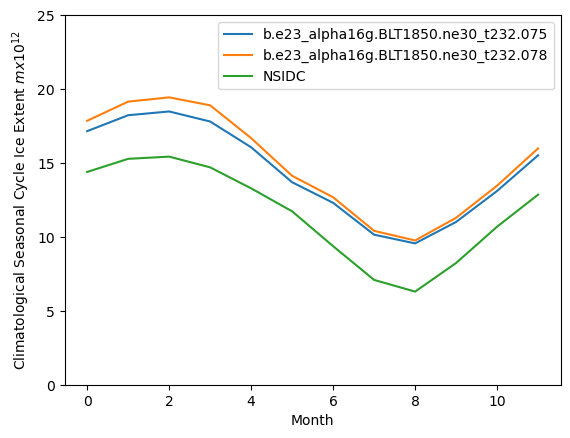

In [14]:

aice1_month = ds1['aice'].groupby("time.month").mean(dim="time",skipna=True)
aice2_month = ds2['aice'].groupby("time.month").mean(dim="time",skipna=True)

mask_tmp1 = np.where(np.logical_and(aice1_month > 0.15, ds1['TLAT'] > 0), 1., 0.)
mask_tmp2 = np.where(np.logical_and(aice2_month > 0.15, ds1['TLAT'] > 0), 1., 0.)

mask_ext1 = xr.DataArray(data=mask_tmp1,dims=["month","nj", "ni"])
mask_ext2 = xr.DataArray(data=mask_tmp2,dims=["month","nj", "ni"])


ext1 = (mask_ext1*tarea).sum(['ni','nj'])*1.0e-12
ext2 = (mask_ext2*tarea).sum(['ni','nj'])*1.0e-12

plt.plot(ext1)
plt.plot(ext2)
plt.plot(nsidc_clim)

plt.ylim((0,25))
plt.xlabel("Month")
plt.ylabel("Climatological Seasonal Cycle Ice Extent $m x 10^{12}$")
plt.legend([case1,case2,"NSIDC"])


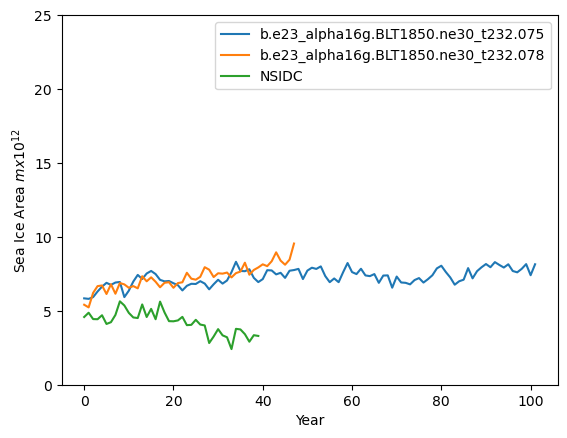

In [15]:
ds1_area = (tarea*ds1.aice).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-12
ds2_area = (tarea*ds2.aice).where(TLAT>0).sum(dim=['nj','ni'])*1.0e-12

ds1_sep = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

plt.plot(ds1_sep)
plt.plot(ds2_sep)
plt.plot(sep_area)

plt.ylim((0,25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $mx10^{12}$")
plt.legend([case1,case2,"NSIDC"])

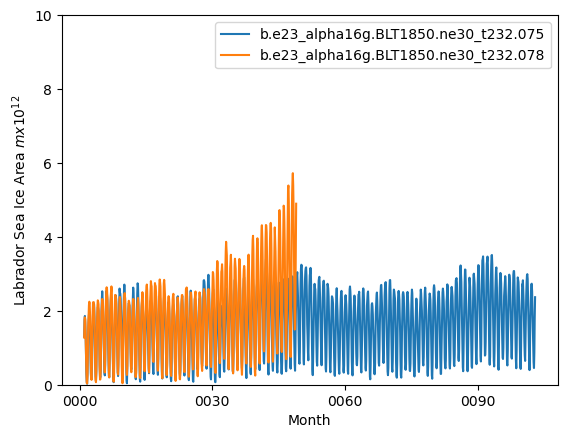

In [16]:

latm = cice_masks['Lab_lat']
lonm = cice_masks['Lab_lon']

lon = np.where(TLON < 0, TLON+360.,TLON)

mask1 = np.where(np.logical_and(TLAT > latm[0], TLAT < latm[1]),1.,0.)
mask2 = np.where(np.logical_or(lon > lonm[0], lon < lonm[1]),1.,0.)
mask = mask1*mask2

ds1_lab = (mask*tarea*ds1.aice).sum(dim=['nj','ni'])*1.0e-12
ds2_lab = (mask*tarea*ds2.aice).sum(dim=['nj','ni'])*1.0e-12

ds1_lab.plot()
ds2_lab.plot()

plt.ylim((0,10))
plt.xlabel("Month")
plt.ylabel("Labrador Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

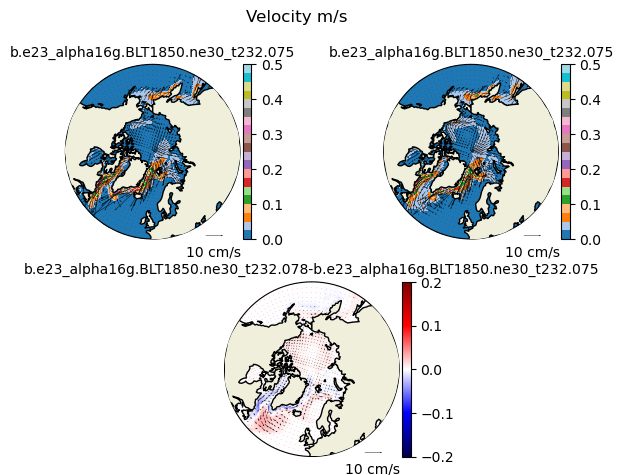

In [17]:
uvel1 = ds1_ann['uvel'].isel(time=slice(-nyears,None)).mean("time").squeeze()
vvel1 = ds1_ann['vvel'].isel(time=slice(-nyears,None)).mean("time").squeeze()
uvel2 = ds2_ann['uvel'].isel(time=slice(-nyears,None)).mean("time").squeeze()
vvel2 = ds2_ann['vvel'].isel(time=slice(-nyears,None)).mean("time").squeeze()
ds_angle = xr.open_dataset("/glade/derecho/scratch/dbailey/ADF/b.e23_alpha16g.BLT1850.ne30_t232.075c/ts/angle.nc")
angle = ds_angle['ANGLE']

vect_diff(uvel1,vvel1,uvel2,vvel2,angle,"N")

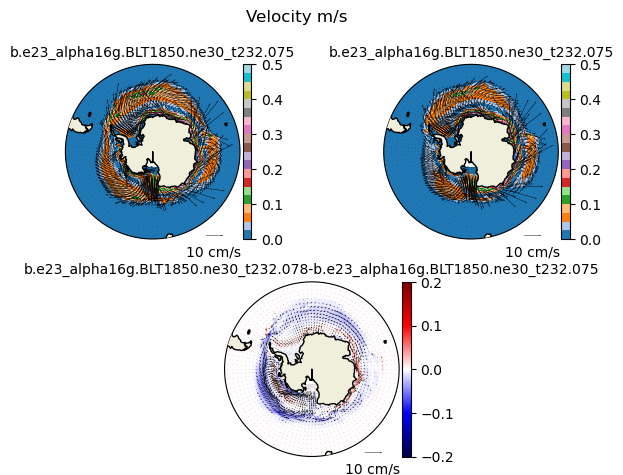

In [18]:
vect_diff(uvel1,vvel1,uvel2,vvel2,angle,"S")